In [337]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
seed = 1
import numpy as np
import random
np.random.seed(seed)
random.seed(seed)
import os 
import csv
import pickle
import time
import h5py
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy.ma as ma

os.environ['CUDA_VISIBLE_DEVICE'] = '4'
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
# config.gpu_options.per_process_gpu_memory_fraction = 0.2

In [448]:
from utils import load_poi2region, get_sequences, digitize_datetime, group_data_by_id
from tqdm import tqdm
from dataloader import load_data, group_data_by_id
from parser import get_parser

In [5]:
args = get_parser(['--CITY', 'NYC'])

In [11]:
origin_data, dicts = load_data(os.path.join(args.ROOT, 'data','{}_INTV_processed_voc5_len2_setting_WITH_GPS_WITH_TIME_WITH_USERID.pk'.format(args.CITY) ))

In [31]:
seqs = get_sequences(origin_data)
trainset, testset = devide_train_and_test(seqs)

In [449]:
from utils import load_embeddings

In [444]:
def get_GE_embeddings(args):
    def complement_embeddings(embeddings, N):
        tmp = np.zeros(shape=(N, embeddings.shape[1]-1))
        for i, emb in enumerate(embeddings):
            id = int(emb[0])
            tmp[id][:] = emb[1:]
        return tmp

    embeddings = load_embedding_from_text(os.path.join('data', 'embeddings', args.pattern, '{}_no_word'.format(args.CITY), 'net_POI_vec.txt'))[:,1:]
    region_embeddings = complement_region_embeddings(load_embedding_from_text(os.path.join('data', 'embeddings', args.pattern, '{}_no_word'.format(args.CITY), 'net_reg_vec.txt')),N=100)
    time_embeddings = complement_embeddings(load_embedding_from_text(os.path.join('data', 'embeddings', args.pattern, '{}_no_word'.format(args.CITY), 'net_time_vec.txt')), args.n_timeslot)
    return embeddings, region_embeddings, time_embeddings

def get_ST_embeddings(args, path=None):
    path = os.path.join(args.ROOT, 'STSkipgram', 'benchmark_{}'.format(args.CITY)) if path is None else path
    sem_embeds = load_embeddings(os.path.join(path, '{}_sem_emb.h5'.format(args.CITY)))
    embeddings = load_embeddings(os.path.join(path, '{}_embeddings.h5'.format(args.CITY)))
    time_embeddings = load_embeddings(os.path.join(path, '{}_time_embeddings.h5'.format(args.CITY)))
    return sem_embeds, embeddings, time_embeddings

def get_SK_wot_embeddings(args, path=None):
    path = os.path.join(args.ROOT, 'SkipGram', 'benchmark_{}_wo_time'.format(args.CITY)) if path is None else path
    embeddings = load_embeddings(os.path.join(path, '{}_embeddings.h5'.format(args.CITY)))
    return embeddings

def get_SK_wt_embeddings(args, path=None):
    path = os.path.join(args.ROOT, 'SkipGram', 'benchmark_{}_with_time'.format(args.CITY)) if path is None else path
    embeddings = load_embeddings(os.path.join(path, '{}_embeddings.h5'.format(args.CITY)))
    time_embeddings = load_embeddings(os.path.join(path, '{}_time.h5'.format(args.CITY)))
    return embeddings, time_embeddings

def get_PV_embeddings(args, path=None):
    path = os.path.join(args.ROOT, 'Baseline', 'Poi2vec', 'exp', 'no_weight') if path is None else path
    embeddings = load_embeddings(os.path.join(path, '{}_embeddings.h5'.format(args.CITY)))
    return embeddings

In [447]:
results = {}
results['GE'] = get_recommandation_result(testset, args, poi2region, get_GE_embeddings(args), mode='GE')
results['STSG'] = get_recommandation_result(testset, args, poi2region, get_ST_embeddings(args), mode='STSG')
results['Skipgram_wot'] = get_recommandation_result(testset, args, poi2region, get_SK_wot_embeddings(args), mode='Skipgram_wot')
results['Skipgram_wt'] = get_recommandation_result(testset, args, poi2region, get_SK_wt_embeddings(args), mode='Skipgram_wt')



  0%|          | 0/1044 [00:00<?, ?it/s]

  0%|          | 1/1044 [00:00<01:55,  9.02it/s]

loaded embeddings from data/embeddings/hand/NYC_no_word/net_POI_vec.txt, shape (5453, 101)
loaded embeddings from data/embeddings/hand/NYC_no_word/net_reg_vec.txt, shape (89, 101)
loaded embeddings from data/embeddings/hand/NYC_no_word/net_time_vec.txt, shape (6, 101)




  1%|          | 7/1044 [00:00<00:31, 32.58it/s]

  1%|          | 13/1044 [00:00<00:25, 40.49it/s]

  2%|▏         | 19/1044 [00:00<00:24, 42.45it/s]

  2%|▏         | 24/1044 [00:00<00:23, 42.82it/s]

  3%|▎         | 33/1044 [00:00<00:20, 49.87it/s]

  4%|▍         | 42/1044 [00:00<00:19, 52.20it/s]

  5%|▍         | 51/1044 [00:00<00:17, 55.85it/s]

  6%|▌         | 60/1044 [00:01<00:16, 58.45it/s]

  6%|▋         | 67/1044 [00:01<00:19, 50.38it/s]

  7%|▋         | 77/1044 [00:01<00:18, 51.99it/s]

  8%|▊         | 83/1044 [00:01<00:20, 46.29it/s]

  9%|▊         | 89/1044 [00:01<00:20, 46.76it/s]

  9%|▉         | 94/1044 [00:02<00:21, 44.11it/s]

 10%|▉         | 100/1044 [00:02<00:21, 43.29it/s]

 11%|█         | 113/1044 [00:02<00:20, 46.15it/s]

 11%|█▏        | 119/1044 [00:02<00:20, 44.55it/s]

 13%|█▎        | 132/1044 [00:02<00:19, 46.06it/s]

 13%|█▎        | 140/1044 [00:02<00:19, 47.20it/s]

 14%|█▍        | 147/1044 [00:03<00:18, 47.61it/s]

 15%|█▌        | 158/104

  0%|          | 1/1044 [00:00<02:34,  6.74it/s]

Reading dadta from /home/haibin2/data/checkins/STSkipgram/benchmark_NYC/NYC_sem_emb.h5
Reading dadta from /home/haibin2/data/checkins/STSkipgram/benchmark_NYC/NYC_embeddings.h5
Reading dadta from /home/haibin2/data/checkins/STSkipgram/benchmark_NYC/NYC_time_embeddings.h5




  1%|          | 7/1044 [00:00<00:39, 26.05it/s]

  1%|          | 13/1044 [00:00<00:31, 32.79it/s]

  2%|▏         | 19/1044 [00:00<00:29, 35.28it/s]

  2%|▏         | 24/1044 [00:00<00:28, 36.00it/s]

  3%|▎         | 33/1044 [00:00<00:24, 41.76it/s]

  4%|▍         | 42/1044 [00:00<00:22, 44.70it/s]

  5%|▍         | 50/1044 [00:01<00:20, 48.02it/s]

  6%|▌         | 59/1044 [00:01<00:19, 51.46it/s]

  6%|▋         | 66/1044 [00:01<00:22, 43.39it/s]

  7%|▋         | 72/1044 [00:01<00:22, 43.60it/s]

  7%|▋         | 78/1044 [00:01<00:23, 40.42it/s]

  8%|▊         | 83/1044 [00:02<00:29, 32.37it/s]

  8%|▊         | 87/1044 [00:02<00:30, 31.66it/s]

  9%|▊         | 90/1044 [00:03<00:31, 30.00it/s]

  9%|▉         | 93/1044 [00:03<00:31, 29.75it/s]

  9%|▉         | 96/1044 [00:03<00:32, 29.21it/s]

 10%|▉         | 100/1044 [00:03<00:32, 28.85it/s]

 11%|█         | 111/1044 [00:03<00:29, 31.12it/s]

 11%|█         | 116/1044 [00:03<00:31, 29.74it/s]

 12%|█▏        | 124/1044 [

 69%|██████▉   | 718/1044 [00:28<00:12, 25.36it/s]

 69%|██████▉   | 722/1044 [00:28<00:12, 25.30it/s]

 69%|██████▉   | 725/1044 [00:28<00:12, 25.30it/s]

 70%|██████▉   | 730/1044 [00:28<00:12, 25.33it/s]

 70%|███████   | 733/1044 [00:28<00:12, 25.31it/s]

 70%|███████   | 736/1044 [00:29<00:12, 25.10it/s]

 71%|███████   | 740/1044 [00:29<00:12, 25.08it/s]

 71%|███████▏  | 745/1044 [00:29<00:11, 25.16it/s]

 72%|███████▏  | 748/1044 [00:29<00:11, 25.17it/s]

 72%|███████▏  | 753/1044 [00:29<00:11, 25.24it/s]

 73%|███████▎  | 760/1044 [00:29<00:11, 25.36it/s]

 73%|███████▎  | 764/1044 [00:30<00:11, 25.41it/s]

 74%|███████▍  | 771/1044 [00:30<00:10, 25.50it/s]

 75%|███████▍  | 779/1044 [00:30<00:10, 25.66it/s]

 75%|███████▌  | 784/1044 [00:30<00:10, 25.54it/s]

 75%|███████▌  | 788/1044 [00:30<00:10, 25.54it/s]

 76%|███████▌  | 792/1044 [00:31<00:09, 25.54it/s]

 77%|███████▋  | 799/1044 [00:31<00:09, 25.62it/s]

 77%|███████▋  | 803/1044 [00:31<00:09, 25.66it/s]

 77%|███████

Reading dadta from /home/haibin2/data/checkins/SkipGram/benchmark_NYC_wo_time/NYC_embeddings.h5




  1%|          | 7/1044 [00:00<00:32, 32.14it/s]

  1%|          | 13/1044 [00:00<00:28, 35.76it/s]

  2%|▏         | 19/1044 [00:00<00:29, 34.68it/s]

  2%|▏         | 24/1044 [00:00<00:30, 33.57it/s]

  3%|▎         | 33/1044 [00:00<00:26, 37.86it/s]

  4%|▍         | 40/1044 [00:00<00:24, 40.91it/s]

  4%|▍         | 45/1044 [00:01<00:24, 41.01it/s]

  5%|▍         | 51/1044 [00:01<00:23, 42.30it/s]

  6%|▌         | 59/1044 [00:01<00:22, 44.75it/s]

  6%|▌         | 65/1044 [00:01<00:24, 40.79it/s]

  7%|▋         | 70/1044 [00:01<00:25, 37.97it/s]

  7%|▋         | 77/1044 [00:01<00:24, 38.68it/s]

  8%|▊         | 82/1044 [00:02<00:29, 32.20it/s]

  8%|▊         | 86/1044 [00:02<00:30, 31.67it/s]

  9%|▊         | 90/1044 [00:02<00:30, 30.89it/s]

  9%|▉         | 94/1044 [00:03<00:30, 30.69it/s]

 10%|▉         | 100/1044 [00:03<00:30, 30.80it/s]

 11%|█         | 111/1044 [00:03<00:28, 33.14it/s]

 11%|█         | 117/1044 [00:03<00:29, 31.63it/s]

 12%|█▏        | 126/1044 [

 77%|███████▋  | 804/1044 [00:27<00:08, 28.79it/s]

 78%|███████▊  | 810/1044 [00:28<00:08, 28.87it/s]

 78%|███████▊  | 816/1044 [00:28<00:07, 28.98it/s]

 79%|███████▉  | 825/1044 [00:28<00:07, 29.19it/s]

 80%|███████▉  | 831/1044 [00:28<00:07, 29.28it/s]

 80%|████████  | 837/1044 [00:28<00:07, 29.27it/s]

 81%|████████  | 844/1044 [00:28<00:06, 29.31it/s]

 81%|████████▏ | 849/1044 [00:29<00:06, 29.16it/s]

 82%|████████▏ | 853/1044 [00:29<00:06, 29.15it/s]

 82%|████████▏ | 858/1044 [00:29<00:06, 29.19it/s]

 83%|████████▎ | 864/1044 [00:29<00:06, 29.24it/s]

 83%|████████▎ | 868/1044 [00:29<00:06, 29.21it/s]

 84%|████████▍ | 875/1044 [00:29<00:05, 29.31it/s]

 84%|████████▍ | 879/1044 [00:30<00:05, 29.30it/s]

 85%|████████▍ | 883/1044 [00:30<00:05, 29.30it/s]

 85%|████████▍ | 887/1044 [00:30<00:05, 29.32it/s]

 85%|████████▌ | 892/1044 [00:30<00:05, 29.37it/s]

 86%|████████▌ | 898/1044 [00:30<00:04, 29.40it/s]

 86%|████████▋ | 902/1044 [00:30<00:04, 29.41it/s]

 87%|███████

Reading dadta from /home/haibin2/data/checkins/SkipGram/benchmark_NYC_with_time/NYC_embeddings.h5
Reading dadta from /home/haibin2/data/checkins/SkipGram/benchmark_NYC_with_time/NYC_time.h5




  0%|          | 1/1044 [00:00<02:44,  6.36it/s]

  1%|          | 6/1044 [00:00<00:53, 19.48it/s]

  1%|          | 11/1044 [00:00<00:38, 26.69it/s]

  1%|▏         | 14/1044 [00:00<00:42, 24.24it/s]

  2%|▏         | 19/1044 [00:00<00:38, 26.88it/s]

  2%|▏         | 24/1044 [00:00<00:35, 28.62it/s]

  3%|▎         | 33/1044 [00:00<00:29, 33.83it/s]

  4%|▎         | 39/1044 [00:01<00:28, 35.72it/s]

  4%|▍         | 44/1044 [00:01<00:28, 35.50it/s]

  5%|▍         | 50/1044 [00:01<00:26, 37.20it/s]

  5%|▌         | 56/1044 [00:01<00:25, 38.21it/s]

  6%|▌         | 61/1044 [00:01<00:25, 38.34it/s]

  6%|▋         | 66/1044 [00:01<00:28, 34.41it/s]

  7%|▋         | 70/1044 [00:02<00:28, 34.47it/s]

  7%|▋         | 77/1044 [00:02<00:27, 35.06it/s]

  8%|▊         | 81/1044 [00:02<00:32, 29.43it/s]

  8%|▊         | 85/1044 [00:02<00:32, 29.09it/s]

  8%|▊         | 88/1044 [00:03<00:32, 28.98it/s]

  9%|▊         | 91/1044 [00:03<00:34, 27.25it/s]

  9%|▉         | 94/1044 [00:03

 82%|████████▏ | 853/1044 [00:25<00:05, 33.54it/s]

 82%|████████▏ | 858/1044 [00:25<00:05, 33.59it/s]

 83%|████████▎ | 864/1044 [00:25<00:05, 33.64it/s]

 83%|████████▎ | 869/1044 [00:25<00:05, 33.63it/s]

 84%|████████▍ | 876/1044 [00:25<00:04, 33.73it/s]

 84%|████████▍ | 881/1044 [00:26<00:04, 33.68it/s]

 85%|████████▍ | 886/1044 [00:26<00:04, 33.71it/s]

 85%|████████▌ | 892/1044 [00:26<00:04, 33.78it/s]

 86%|████████▌ | 898/1044 [00:26<00:04, 33.81it/s]

 86%|████████▋ | 903/1044 [00:26<00:04, 33.86it/s]

 87%|████████▋ | 908/1044 [00:26<00:04, 33.80it/s]

 88%|████████▊ | 914/1044 [00:27<00:03, 33.76it/s]

 89%|████████▊ | 925/1044 [00:27<00:03, 34.03it/s]

 90%|████████▉ | 937/1044 [00:27<00:03, 34.03it/s]

 90%|█████████ | 942/1044 [00:27<00:03, 33.98it/s]

 91%|█████████ | 949/1044 [00:27<00:02, 34.08it/s]

 91%|█████████▏| 954/1044 [00:28<00:02, 33.95it/s]

 93%|█████████▎| 966/1044 [00:28<00:02, 34.25it/s]

 93%|█████████▎| 973/1044 [00:28<00:02, 34.35it/s]

 94%|███████

In [321]:
sts, ste, stt = get_ST_embeddings(args)

Reading dadta from /home/haibin2/data/checkins/STSkipgram/benchmark/NYC_sem_emb.h5
Reading dadta from /home/haibin2/data/checkins/STSkipgram/benchmark/NYC_embeddings.h5
Reading dadta from /home/haibin2/data/checkins/STSkipgram/benchmark/NYC_time_embeddings.h5


In [72]:
args.pattern = 'hand'

In [69]:
poi2region = load_poi2region(os.path.join('data', '{}_poi2region.pk'.format(args.CITY)))

Loading data from data/NYC_poi2region.pk


In [ ]:
result_dicts = {}

In [324]:
import tensorflow as tf

In [446]:
class Recommander:
    def __init__(self, embeddings, time_embeddings=None, region_embeddings=None, sem_embeddings=None):
        emb = tf.constant(embeddings,dtype=tf.float32)
        time_emb = tf.constant(time_embeddings, dtype=tf.float32) if not time_embeddings is None else None 
        region_emb = tf.constant(region_embeddings, dtype=tf.float32) if not region_embeddings is None else None
        sem_emb = tf.constant(sem_embeddings, dtype=tf.float32) if not sem_embeddings is None else None
        
        self.decays = tf.placeholder(dtype=tf.float32, shape=(None))
        self.t_now = tf.placeholder(dtype=tf.int32, shape=(None))
        self.r_now = tf.placeholder(dtype=tf.int32, shape=(None))
        self.l_xs = tf.placeholder(dtype=tf.int32, shape=(None))
        
        self.user_profile = tf.reduce_sum(tf.nn.embedding_lookup(emb, self.l_xs) * tf.reshape(self.decays, (-1,1)), axis=0, keepdims=True)
        self.score = tf.matmul(self.user_profile, tf.transpose(emb))
        if not time_embeddings is None:
            self.time_emb_now = tf.nn.embedding_lookup(time_emb, self.t_now)
            if not sem_embeddings is None:
                self.score += tf.matmul(self.time_emb_now, tf.transpose(sem_emb))
            else:
                self.score += tf.matmul(self.time_emb_now, tf.transpose(emb))
        if not region_embeddings is None:
            self.r_emb_now = tf.nn.embedding_lookup(region_emb, self.r_now)
            self.score = tf.matmul(self.r_emb_now, tf.transpose(emb))
        self.score = tf.squeeze(self.score)

In [ ]:
c = tf.matmul

In [416]:
sess = tf.Session(config=config)

In [154]:
result = get_recommandation_result(testset, args, poi2region, (embeddings, region_embeddings, time_embeddings), mode='GE')

100%|██████████| 1044/1044 [02:47<00:00,  6.24it/s]

167.37496542930603


In [418]:
sess.run(model.score, {model.decays: np.ones(shape=3), model.l_xs: [1]*3, model.t_now:[1]})

array([[-0.5405644 , -0.4284531 , -0.681084  , ..., -1.6470017 ,
        -1.4667907 , -0.67495763]], dtype=float32)

In [175]:
result = get_recommandation_result(testset, args, poi2region, (ST_sem, ST_emb, ST_time), mode='ST')

100%|██████████| 1044/1044 [00:39<00:00, 26.37it/s]


In [209]:
args.use_decay = True

In [222]:
np.matmul(np.zeros((100)), np.zeros((6,100)).T)

array([0., 0., 0., 0., 0., 0.])

In [231]:
from tqdm import tqdm

In [340]:
tf.reset_default_graph()

In [247]:
result2 = get_recommandation_result(testset, args, poi2region, (SK_embed, SK_time), mode='Skipgram')



  0%|          | 0/1044 [00:00<?, ?it/s]

  0%|          | 2/1044 [00:00<00:52, 19.73it/s]

  1%|          | 6/1044 [00:00<00:44, 23.47it/s]

  1%|          | 11/1044 [00:00<00:36, 28.33it/s]

  1%|          | 13/1044 [00:00<00:45, 22.53it/s]

  2%|▏         | 18/1044 [00:00<00:38, 26.57it/s]

  2%|▏         | 21/1044 [00:00<00:39, 25.72it/s]

  2%|▏         | 25/1044 [00:00<00:37, 26.92it/s]

  3%|▎         | 33/1044 [00:01<00:32, 30.94it/s]

  4%|▍         | 40/1044 [00:01<00:29, 34.11it/s]

  4%|▍         | 45/1044 [00:01<00:28, 34.89it/s]

  5%|▍         | 50/1044 [00:01<00:28, 35.43it/s]

  5%|▌         | 56/1044 [00:01<00:26, 36.92it/s]

  6%|▌         | 61/1044 [00:01<00:26, 37.42it/s]

  6%|▋         | 66/1044 [00:02<00:30, 32.21it/s]

  7%|▋         | 70/1044 [00:02<00:31, 31.18it/s]

  7%|▋         | 76/1044 [00:02<00:30, 32.22it/s]

  8%|▊         | 80/1044 [00:03<00:36, 26.10it/s]

  8%|▊         | 83/1044 [00:03<00:36, 26.22it/s]

  8%|▊         | 86/1044 [00:03<00:37, 2

 68%|██████▊   | 710/1044 [00:29<00:14, 23.80it/s]

 68%|██████▊   | 713/1044 [00:30<00:14, 23.64it/s]

 69%|██████▉   | 718/1044 [00:30<00:13, 23.63it/s]

 69%|██████▉   | 721/1044 [00:30<00:13, 23.64it/s]

 69%|██████▉   | 724/1044 [00:30<00:13, 23.61it/s]

 70%|██████▉   | 728/1044 [00:30<00:13, 23.64it/s]

 70%|███████   | 732/1044 [00:30<00:13, 23.67it/s]

 70%|███████   | 735/1044 [00:31<00:13, 23.43it/s]

 71%|███████   | 740/1044 [00:31<00:12, 23.46it/s]

 71%|███████   | 743/1044 [00:31<00:12, 23.47it/s]

 72%|███████▏  | 747/1044 [00:31<00:12, 23.47it/s]

 72%|███████▏  | 752/1044 [00:31<00:12, 23.56it/s]

 73%|███████▎  | 758/1044 [00:32<00:12, 23.65it/s]

 73%|███████▎  | 762/1044 [00:32<00:11, 23.67it/s]

 73%|███████▎  | 766/1044 [00:32<00:11, 23.71it/s]

 74%|███████▍  | 771/1044 [00:32<00:11, 23.74it/s]

 75%|███████▍  | 778/1044 [00:32<00:11, 23.86it/s]

 75%|███████▍  | 782/1044 [00:32<00:10, 23.83it/s]

 75%|███████▌  | 786/1044 [00:33<00:10, 23.75it/s]

 76%|███████

In [253]:
poi_result = get_recommandation_result(testset, args, poi2region, (PV_embeddings), mode='POI2VEC')



  0%|          | 0/1044 [00:00<?, ?it/s]

  1%|          | 6/1044 [00:00<00:24, 42.79it/s]

  1%|          | 12/1044 [00:00<00:24, 42.35it/s]

  1%|▏         | 15/1044 [00:00<00:28, 36.58it/s]

  2%|▏         | 19/1044 [00:00<00:28, 36.17it/s]

  2%|▏         | 24/1044 [00:00<00:28, 35.59it/s]

  3%|▎         | 33/1044 [00:00<00:25, 40.34it/s]

  4%|▍         | 40/1044 [00:00<00:23, 43.51it/s]

  4%|▍         | 45/1044 [00:01<00:22, 43.71it/s]

  5%|▍         | 51/1044 [00:01<00:23, 42.44it/s]

  5%|▌         | 56/1044 [00:01<00:23, 41.36it/s]

  6%|▌         | 61/1044 [00:01<00:23, 41.73it/s]

  6%|▋         | 66/1044 [00:01<00:27, 35.44it/s]

  7%|▋         | 70/1044 [00:01<00:27, 35.59it/s]

  7%|▋         | 77/1044 [00:02<00:26, 36.38it/s]

  8%|▊         | 81/1044 [00:02<00:32, 29.97it/s]

  8%|▊         | 85/1044 [00:02<00:33, 28.85it/s]

  8%|▊         | 88/1044 [00:03<00:33, 28.31it/s]

  9%|▊         | 91/1044 [00:03<00:38, 25.08it/s]

  9%|▉         | 94/1044 [00:03<00:37, 

 68%|██████▊   | 710/1044 [00:29<00:14, 23.83it/s]

 68%|██████▊   | 712/1044 [00:29<00:13, 23.75it/s]

 68%|██████▊   | 714/1044 [00:30<00:13, 23.65it/s]

 69%|██████▉   | 718/1044 [00:30<00:13, 23.56it/s]

 69%|██████▉   | 721/1044 [00:30<00:13, 23.55it/s]

 69%|██████▉   | 723/1044 [00:30<00:13, 23.48it/s]

 69%|██████▉   | 725/1044 [00:30<00:13, 23.44it/s]

 70%|██████▉   | 728/1044 [00:31<00:13, 23.46it/s]

 70%|██████▉   | 730/1044 [00:31<00:13, 23.44it/s]

 70%|███████   | 733/1044 [00:31<00:13, 23.35it/s]

 70%|███████   | 735/1044 [00:31<00:13, 23.04it/s]

 71%|███████   | 740/1044 [00:32<00:13, 23.05it/s]

 71%|███████   | 743/1044 [00:32<00:13, 23.07it/s]

 72%|███████▏  | 748/1044 [00:32<00:12, 23.15it/s]

 72%|███████▏  | 755/1044 [00:32<00:12, 23.28it/s]

 73%|███████▎  | 761/1044 [00:32<00:12, 23.39it/s]

 73%|███████▎  | 766/1044 [00:32<00:11, 23.38it/s]

 74%|███████▍  | 770/1044 [00:32<00:11, 23.42it/s]

 74%|███████▍  | 774/1044 [00:33<00:11, 23.40it/s]

 75%|███████

In [256]:
ge_result = np.array(res_mat)
sk_result = np.array(result2)
sts_result = np.array(result)

In [155]:
res_mat = np.array(a)

In [177]:
def get_k_accuracy(res_mat):
    res_mat = np.array(res_mat)
    return [np.mean(np.sum(res_mat[:,:k], axis=1) > 0) for k in [1,5,10,15,20]]

In [178]:
get_k_accuracy(res_mat)

[0.10343443354148082,
 0.2645851917930419,
 0.36752899197145406,
 0.42649420160570917,
 0.4631578947368421]

In [179]:
get_k_accuracy(result)

[0.1328278322925959,
 0.26882247992863517,
 0.3765388046387154,
 0.43599464763603923,
 0.47756467439785905]

In [251]:
get_k_accuracy(result2)

[0.14491525423728813,
 0.18010704727921498,
 0.19531668153434434,
 0.20557537912578056,
 0.2124442462087422]

In [255]:
get_k_accuracy(poi_result)

[0.026583407671721678,
 0.1888492417484389,
 0.2084299732381802,
 0.22042818911685993,
 0.2286351471900089]

In [259]:
res_dicts = {key:get_k_accuracy(x) for key, x in zip(['LOC2VEC', 'STgram', 'skipgram', 'GE'], 
                                                     [poi_result, sts_result, sk_result, ge_result])}

In [306]:
acc_dicts = {key: get_k_accuracy(v) for key, v in results.items()}

In [275]:
res_dict = res_dicts

In [296]:
def compare_models(res_dict, Ks=[1,5,10,15,20]):
    Ks = [1,5,10,15,20]
    keys = sorted(res_dict.keys())
    color_map = [np.random.uniform(size=(3)) for i in range(len(keys))]
    width = 0.3
    gap = 1
    position = 0
    tick_pos = []
    for j, k in enumerate(Ks):
        xs = np.linspace(position, position+len(keys)*width, len(keys))
        tick_pos.append(xs[int(len(xs)/2)])

        values = [res_dict[key][j] for key in keys]
        ptrs = plt.bar(xs, values, width)
        for i, p in enumerate(ptrs): p.set_facecolor(color_map[i])

        position += (width*len(keys)+1 + gap)
    xticks = np.linspace(0, position-1, len(Ks))
    plt.legend(ptrs, keys)
    plt.xticks(tick_pos, ['K={}'.format(k) for k in Ks])
    # plt.xticklabels()
    plt.title('recommendation')

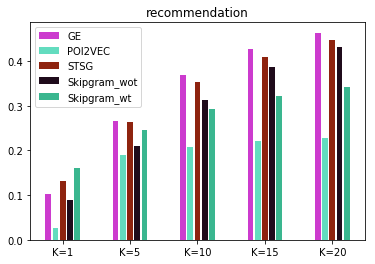

In [307]:
compare_models(acc_dicts)